In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('dark')
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline



train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')
train.head(4)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S


**Посмотрим на наличие/отсутствие пропусков в данных у различных переменных**

In [2]:
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Text(0.5, 1.0, 'Число выживших/погибших:')

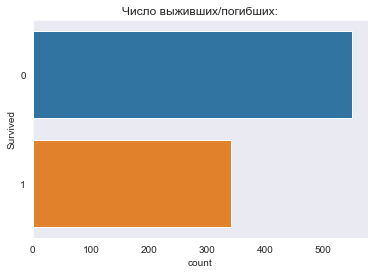

In [3]:
sns.countplot(y=train['Survived']).set_title('Число выживших/погибших:')

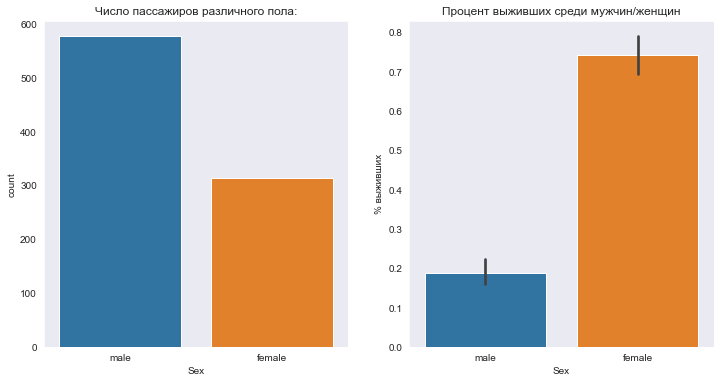

In [4]:
fig, axarr = plt.subplots(1, 2, figsize=(12,6))
a = sns.countplot(train['Sex'], ax=axarr[0]).set_title('Число пассажиров различного пола:')
axarr[1].set_title('Процент выживших среди мужчин/женщин')
b = sns.barplot(x='Sex', y='Survived', data=train, ax=axarr[1]).set_ylabel('% выживших')

**Число мужчин существенно больше, но число выживших среди женщин на несколько порядков выше** 

In [5]:
train.groupby('Pclass').Survived.mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

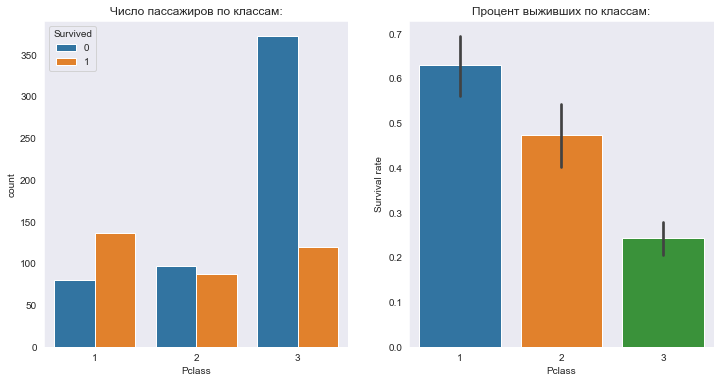

In [6]:
fig, axarr = plt.subplots(1, 2, figsize = (12, 6))
a = sns.countplot(x='Pclass',hue='Survived',data=train,ax=axarr[0]).set_title('Число пассажиров по классам:')
axarr[1].set_title('Процент выживших по классам:')
b = sns.barplot(x='Pclass', y='Survived', data=train, ax=axarr[1]).set_ylabel('Survival rate')

**Процент выживших выше среди пассажиров более дорогих классов**

In [7]:
train.groupby(['Pclass', 'Sex']).Survived.mean()

Pclass  Sex   
1       female    0.968085
        male      0.368852
2       female    0.921053
        male      0.157407
3       female    0.500000
        male      0.135447
Name: Survived, dtype: float64

В совокупности пол и класс дают высокий уровень выживаемости:  по крайней мере женщинам, путешествующим первым классом

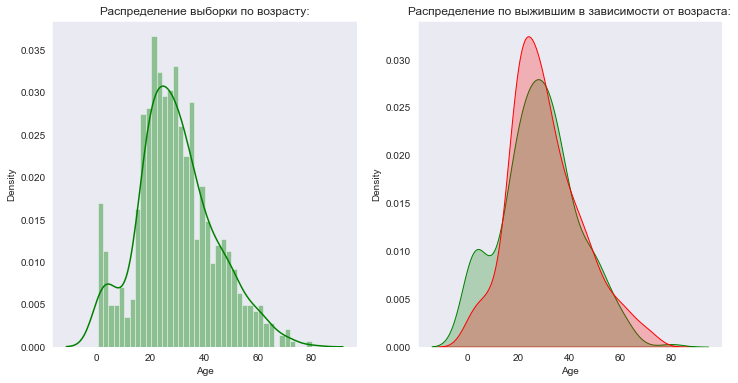

In [8]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
a = sns.distplot(train['Age'],ax=ax[0], bins= 40, color='g').set_title('Распределение выборки по возрасту:')
b = sns.kdeplot(train['Age'][train.Survived == 1],color='g', shade=True, ax = ax[1])
b.set_title('Распределение по выжившим в зависимости от возраста:')
b = sns.kdeplot(train['Age'][train.Survived == 0], color='r', shade = True, ax = ax[1])

Пристствует пик выживаемости среди пассажиров до ~ 10-12 лет 

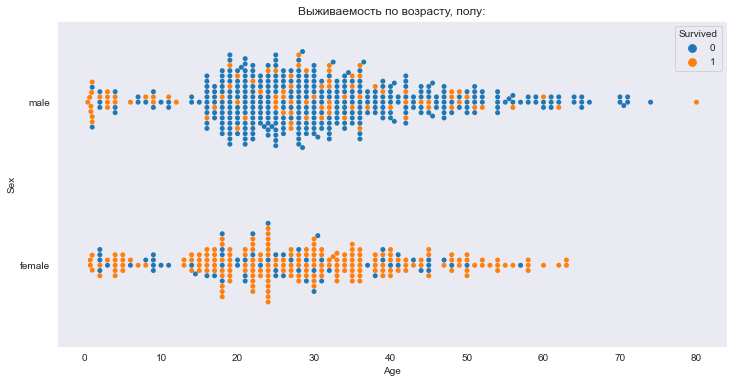

In [9]:
plt.figure(figsize=(12,6))
a = sns.swarmplot(x='Age', y = 'Sex', hue = 'Survived', data=train).set_title('Выживаемость по возрасту, полу:')

**Выживаемость выше до ~ 10-12 лет вне зависимости от пола**

In [10]:
train.Fare.describe() # Цена за билет

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

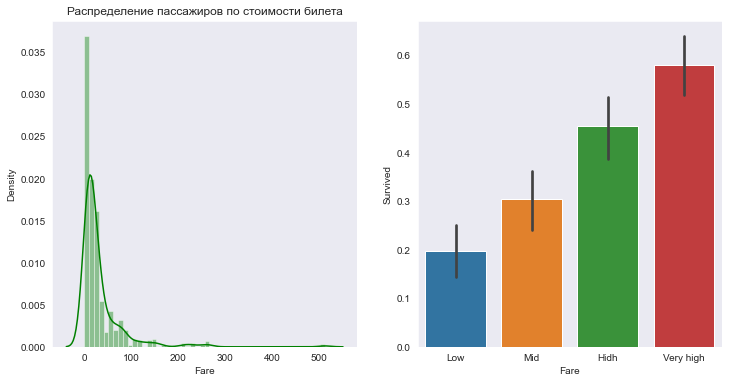

In [11]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6))
a = sns.distplot(train['Fare'], ax = ax[0], color='g').set_title('Распределение пассажиров по стоимости билета')
fare_ranges = pd.qcut(train['Fare'], 4, labels=['Low','Mid','Hidh','Very high'])
b = sns.barplot(x=fare_ranges, y = train['Survived']).set_title('')

Обнаружились пассажиры с 0 стоимостью билета

**Откуда прибыли пассажиры**

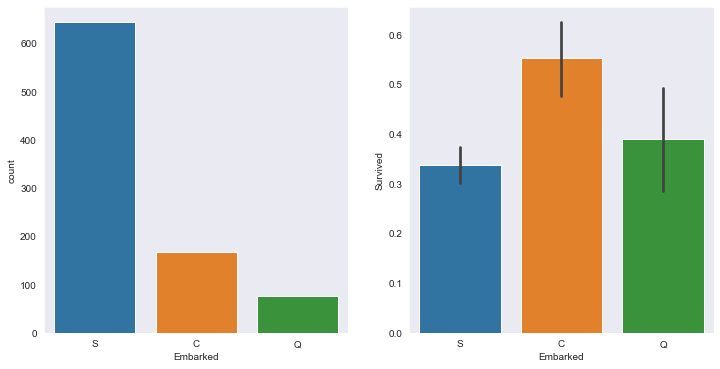

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12, 6))
a = sns.countplot(x='Embarked',data=train, ax= ax[0]).set_title
b = sns.barplot(x=train.Embarked, y = train.Survived, ax = ax[1])

Попробуем достать дополнительную информацию из полного имени пассажира 

In [13]:
train['Title'] = train.Name.apply(lambda x: x.split(',')[1].split('.')[0].strip())
train.Title.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Major             2
Mlle              2
Jonkheer          1
Sir               1
Don               1
Mme               1
Lady              1
Capt              1
the Countess      1
Ms                1
Name: Title, dtype: int64

Много с небольшими значениями. Попробуем добавить к уже существующим группам

In [14]:
train['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss', inplace=True)
train['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

In [15]:
train['Title'].value_counts()

Mr        525
Miss      188
Mrs       125
Master     40
Dr          7
Rev         6
Name: Title, dtype: int64

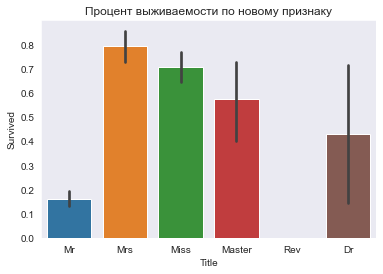

In [16]:
plt.plot(figsize=(12,4))
a = sns.barplot(x=train.Title, y = train.Survived).set_title('Процент выживаемости по новому признаку')

In [17]:
print('У признака Cabin cлишком много пропущенных значений = {0}  в сравнении с общей выборкой  = {1}, ничего делать над ним не будем'.format(train.Cabin.isna().sum(),train.shape[0]))

У признака Cabin cлишком много пропущенных значений = 687  в сравнении с общей выборкой  = 891, ничего делать над ним не будем


In [18]:
train['Ticket_2let'] = train.Ticket.apply(lambda x: x[:2])
train['Ticket_len'] = train.Ticket.apply(lambda x: len(x))

**Так же пристуствуют два признака, определяющие общее число родственников в семье. Это SibSp, Parch**

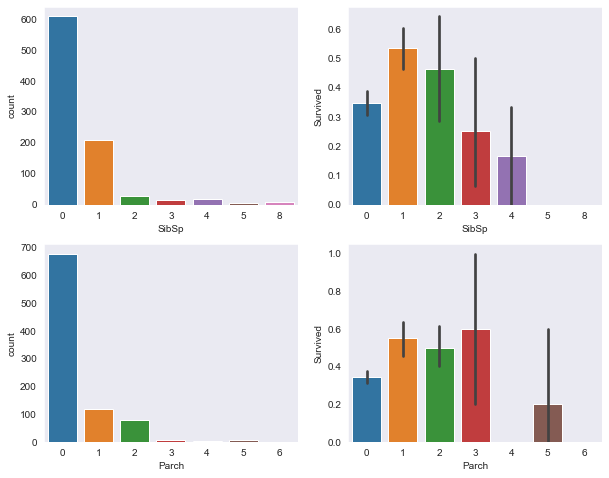

In [19]:
fig, ax = plt.subplots(2,2,figsize = (10, 8))
a = sns.countplot(x='SibSp',data=train, ax= ax[0,0]).set_title
b = sns.barplot(x=train.SibSp, y = train.Survived, ax = ax[0,1])
c = sns.countplot(x='Parch',data=train, ax= ax[1,0]).set_title
d = sns.barplot(x=train.Parch, y = train.Survived, ax = ax[1,1])

Вероятно, пристствует некий паттерн в том, как выживают пассажиры с определенным число родственников на корабле

In [20]:
train['Family_size'] = train['SibSp'] + train['Parch'] + 1

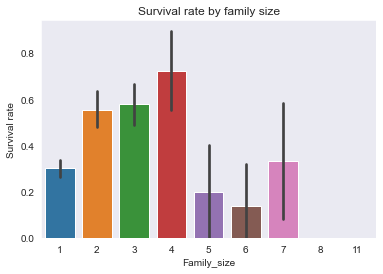

In [21]:
plt.title('Survival rate by family size')
g = sns.barplot(x='Family_size', y='Survived', data=train).set_ylabel('Survival rate')

Добавим так же тип семьи

In [48]:
train['Family_type'] = pd.cut(train['Family_size'], bins = [0, 1, 4, 7, 11], labels=['Solo', 'Small', 'Big', 'Very big'])

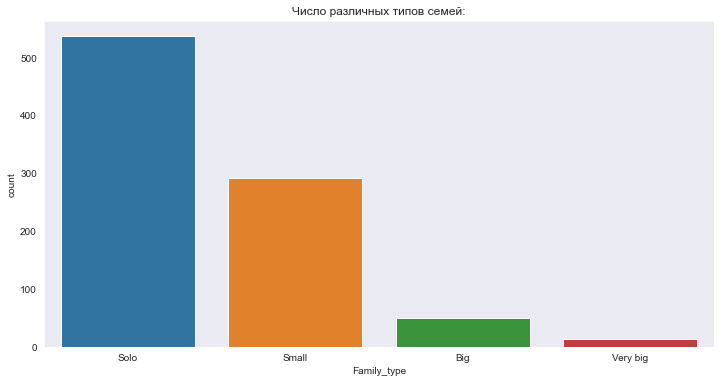

In [58]:
plt.figure(figsize=(12, 6))
a = sns.countplot(train['Family_type']).set_title('Число различных типов семей:')

**Выполним python скрипт с выполненной предобработкой данных (в т.ч. для теста) с последующим отбором модели/оценкой качества, сабмитом с использованием API**

In [54]:
df = pd.read_csv('Data/train.csv')
df_test  = pd.read_csv('Data/test.csv')
df = pd.concat([df, df_test],ignore_index=True)

In [58]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,25.0,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,25.0,0,0,359309,8.0500,NaN,S


In [56]:
df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

177